In [1]:
# Setting up google drive 
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
import sys
sys.path.append('/content/gdrive/MyDrive/Colab Notebooks')

Mounted at /content/gdrive


In [2]:
%matplotlib inline
import my_utils as mu
import torch
import random

# Linear Regression Implementation from Scratch

* Goal: implement the entire method from scratch, including the data pipeline, the model, the loss function, and the minibatch stochastic gradient descent optimizer.
    * Deep learning frameworks can automate nearly all of this work!

* For training we need the following:
    * Create and read dataset
    * Create linear regression model ($y = \mathbf{w}^{T}\mathbf{x} + b$)
$\textrm{}$
    * Initialize parameters $(\mathbf{w}, b)$
    * Define loss function (squared loss function) and compute the gradient w.r.t. model parameters
        * Since nobody wants to compute gradients explicitly we use automatic differentiation
    * Define optimization algorithm (sgd)
* Then, we execute the following loop:
    * Repeat until done
        * Compute gradient $\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$
        * Update parameters $(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$


# Generating the Dataset

* We construct an artificial dataset according to a linear model with additive noise.
* Goal: to recover the model's parameters using the dataset.
* Dataset contains 1000 examples, each consisting of 2 features sampled from a Gaussian distribution. Dataset is represented by a matrix $\mathbf{X}\in \mathbb{R}^{1000 \times 2}$.
* True parameters (generating our dataset): $\mathbf{w} = [2, -3.4]^\top$ and $b = 4.2$.
* Synthetic labels: according to the following linear model with noise term $\epsilon$:

$$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon.$$

* $\epsilon$ captures potential measurement errors on the features and labels.
* Standard assumptions: $\epsilon$ is zero-mean Gaussian. We set its std to 0.01.

In [3]:
def synthetic_data(w, b, num_examples):  
    """Generate y = Xw + b + noise."""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.mm(X, w) + b
    y += torch.normal(0, 0.01, y.size())
    return X, y.reshape((-1, 1))

In [4]:
true_w = torch.tensor([[2], [-3.4]])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
print(features.size())
print(labels.size())

torch.Size([1000, 2])
torch.Size([1000, 1])


By generating a scatter plot using the second feature `features[:, 1]` and `labels`,
we can clearly observe the linear correlation between the two.


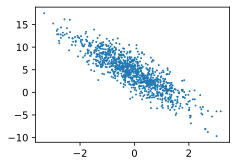

In [5]:
mu.set_figsize()
# The semicolon is for displaying the plot only
mu.plt.scatter(mu.numpy(features[:, 1]), mu.numpy(labels), 1);

# Reading the Dataset

* Training the model consists of making multiple passes over the dataset, grabbing one minibatch of examples at a time, and using them to update our model.
* To facilitate this, in the following code, we define the `data_iter` function
    * It takes a batch size, a matrix of features, and a vector of labels, yielding minibatches of `batch_size`.
        * Each minibatch consists of a tuple of features and labels.


In [6]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

# Show first batch
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    #print(X, '\n', y)
    print(torch.cat((X, y), 1))
    break

tensor([[ 0.1474,  0.1422,  4.0059],
        [-0.2065, -1.3625,  8.4201],
        [ 0.6226, -0.1774,  6.0500],
        [-0.4051,  1.3050, -1.0469],
        [ 0.3285,  1.1401,  0.9747],
        [ 0.1535,  0.2578,  3.6123],
        [-0.1993, -0.3209,  4.8971],
        [ 0.6101, -0.1104,  5.7846],
        [-0.1654, -0.4839,  5.5124],
        [-0.1265,  0.1441,  3.4595]])


* The above iterator requires that we load all the data in memory and that we perform lots of random memory access.
* The built-in iterators implemented in a deep learning framework are considerably more efficient and they can deal with both data stored in files and data fed via data streams.

# Defining the Model

* This consists relating its inputs and parameters to its outputs.
* For linear regression $\mathbf{y} = \mathbf{X}\mathbf{w} + b$ 
    * $\mathbf{Xw}$  is a vector and $b$ is a scalar $\rightarrow$ Broadcasting is used
        * When we add a vector and a scalar, the scalar is added to each component of the vector.


In [7]:
def linreg(X, w, b): 
    """The linear regression model: y=Xw+b
       X: [num_of_examples, num_of_feat]
       w: [num_of_feat, 1]
       b: scalar
       y: [num_of_examples, 1]"""
    return torch.mm(X, w) + b

## Initializing Model Parameters

* Before optimizing our model's parameters by minibatch sgd, we need to have some parameters in the first place.
* In the following code, weights are initialized from a normal distribution with mean 0 and a std of 0.01, and bias as 0.

In [8]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

## Defining the Loss Function

* Squared loss function
* In the implementation, we need to transform the true value `y` into the predicted value's shape `y_hat`.


In [9]:
def squared_loss(y_hat, y): 
    """Squared loss."""
    return (y_hat - y.reshape(y_hat.size())) ** 2 / 2

## Defining the Optimization Algorithm

* Linear regression has a closed-form solution, however, we will use minibatch stochastic gradient descent.
    * Prepares the ground for Deep Learning algorithms

* The following code applies the minibatch stochastic gradient descent update, given a set of parameters, a learning rate, and a batch size.
    * The size of the update step is determined by the learning rate `lr`.
    * Because loss is calculated as a sum over the minibatch of examples, the step is normalized by the batch size, so that it does not depend on batch size.


In [10]:
def sgd(params, lr, batch_size):  
    """Minibatch stochastic gradient descent."""
    for param in params:
        param.data.sub_(lr*param.grad/batch_size)
        param.grad.data.zero_()

# Training Loop
* **In each iteration:** 
    * Grab a minibatch of training examples, and pass them through model to obtain a set of predictions. 
    * Then, calculate the loss, and do backwards pass through the network, to compute the gradients w.r.t. each parameter. 
    * Finally, call `sgd` to update the model parameters.
* **In each epoch:** iterate through the entire dataset using `data_iter` function


In [11]:
lr, num_epochs = 0.03, 3 #hyperparameters
net = linreg
loss = squared_loss

# training loop
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        y_hat = net(X, w, b)
        l = loss(y_hat, y).sum()  # Minibatch loss in `X` and `y`
        l.backward() # Compute gradient on `l` with respect to [`w`, `b`]
        sgd([w, b], lr, batch_size)  # Update parameters using their gradient
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels) # Evaluate model on ALL features from training set
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.022798
epoch 2, loss 0.000083
epoch 3, loss 0.000053


# Evaluation

* Since we  synthesized the dataset ourselves, we know precisely what the true parameters are.
* We can evaluate our success in training by comparing the true parameters with those that we learned through our training loop.
* Note that, we are typically less concerned with recovering true underlying parameters, and more concerned with parameters that lead to highly accurate prediction. 


In [12]:
print(f'error in estimating w: {true_w - w.reshape(true_w.shape)}')
print(f'error in estimating b: {true_b - b}')

error in estimating w: tensor([[9.5844e-05],
        [2.0981e-05]], grad_fn=<SubBackward0>)
error in estimating b: tensor([0.0004], grad_fn=<RsubBackward1>)



# Summary

* We saw how a deep network can be implemented and optimized from scratch, using just tensors and auto differentiation, without any need for defining layers or fancy optimizers.